In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import eikonax.solver as solve
import eikonax.tensorfield as tensorfield
import eikonax.utilities as utils
import eikonax.logging as logging

sns.set_theme(style="ticks")

In [17]:
disable_jit = False
log_compiles = False
mesh_bounds = (-1, 1)
num_points = 100
dimension = 2

solver_data = solve.SolverData(
    tolerance=1e-3,
    max_num_iterations=200,
    loop_type="nonjitted_while",
    max_value=10,
    softmin_order=5,
    drelu_order=10,
    drelu_cutoff=1,
    log_interval=10,
)

logger_data = logging.LoggerSettings(
    log_to_console=True,
    logfile_path=None
)

initial_sites = solve.InitialSites(inds=jnp.array((0,)), values=jnp.array((0,)))

In [18]:
vertices, simplices = utils.create_test_mesh(mesh_bounds, num_points)
adjacent_vertex_inds = utils.get_adjacent_vertex_data(simplices, vertices.shape[0])
parameter_vector = jnp.ones(dimension * simplices.shape[0], dtype=jnp.float32)

field_data = tensorfield.LinearTensorFieldData(
    dimension=dimension, num_simplices=simplices.shape[0]
)
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    tensor_field = tensorfield.LinearTensorField.assemble_field(parameter_vector, field_data)

mesh_data = solve.MeshData(vertices=vertices, adjacent_vertex_inds=adjacent_vertex_inds)
logger = logging.Logger(logger_data)
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    solution = solve.Solver.run(tensor_field, initial_sites, mesh_data, solver_data, logger)

Time[s]:       | #Iterations:   | Tolerance:     | 
--------------------------------------------------
9.081e-02      | 1.000e+01      | 9.798e+00      | 
2.110e-01      | 2.000e+01      | 9.596e+00      | 
2.975e-01      | 3.000e+01      | 9.394e+00      | 
3.889e-01      | 4.000e+01      | 9.192e+00      | 
4.949e-01      | 5.000e+01      | 8.990e+00      | 
5.785e-01      | 6.000e+01      | 8.788e+00      | 
6.722e-01      | 7.000e+01      | 8.586e+00      | 
7.551e-01      | 8.000e+01      | 8.384e+00      | 
8.480e-01      | 9.000e+01      | 8.182e+00      | 
9.383e-01      | 1.000e+02      | 7.522e+00      | 
1.030e+00      | 1.100e+02      | 7.253e+00      | 
1.138e+00      | 1.200e+02      | 9.643e-03      | 
1.232e+00      | 1.300e+02      | 7.901e-04      | 


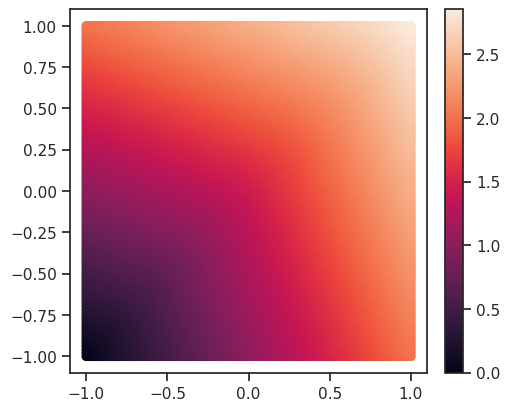

In [10]:
fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
ax.triplot(vertices[:, 0], vertices[:, 1], simplices)
scatter_plot = ax.scatter(vertices[:, 0], vertices[:, 1], c=solution.values)
plt.colorbar(scatter_plot)